# NLP Project
## By BROSSEAU Alexandre & COGORDAN Alexandre

### We load the necessary module

In [1]:
import urllib.request as re
import numpy as np
import pandas as pd
import nltk
import gensim
import re
import gensim.downloader as api
import torch

from collections import defaultdict
from sklearn.metrics import ndcg_score
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from gensim.models.word2vec import Word2Vec
from rank_bm25 import BM25Okapi
from sklearn.metrics import ndcg_score
from sklearn.metrics.pairwise import cosine_similarity
from nltk.stem import WordNetLemmatizer
from transformers import pipeline
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [2]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alexandrecogordan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/alexandrecogordan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### We load the NFCorpus

In [3]:
def loadNFCorpus():
	dir = "./project1-2023/"
	filename = dir +"dev.docs"

	dicDoc={}
	with open(filename) as file:
		lines = file.readlines()
	for line in lines:
		tabLine = line.split('\t')
		key = tabLine[0]
		value = tabLine[1]
		dicDoc[key] = value
	filename = dir + "dev.all.queries"
	dicReq={}
	with open(filename) as file:
		lines = file.readlines()
	for line in lines:
		tabLine = line.split('\t')
		key = tabLine[0]
		value = tabLine[1]
		dicReq[key] = value
	filename = dir + "dev.2-1-0.qrel"
	dicReqDoc=defaultdict(dict)
	with open(filename) as file:
		lines = file.readlines()
	for line in lines:
		tabLine = line.strip().split('\t')
		req = tabLine[0]
		doc = tabLine[2]
		score = int(tabLine[3])
		dicReqDoc[req][doc]=score

	return dicDoc, dicReq, dicReqDoc

#### This is where we'll change our main parameters to test and evaluate the different scores

In [24]:
minimum_word_length = 2
keep_relevant_documents = False
start = 0
end = 150
w2v_vector_size = 300
w2v_window = 50
w2v_min_count = 1
w2v_sg = 0
alpha_value = 1
# chosen_model = 3 # 1 for my model, 2 for glove model, 3 for biovec model

### We preprocess the data

In [5]:
# This function returns a shortened corpus where we only keep the documents that are indicated by start and end
# Keep relevant: only keeps the relevant documents to their respective queries

def shorten_dictionary(doc, req, req_doc, keep_relevant, start, end):
  kept_doc = []
  kept_req = []
  kept_req_doc = defaultdict(dict)

  if(keep_relevant):
    req_doc = {outer_key: {inner_key: inner_value for inner_key, inner_value in inner_dict.items() if inner_value == 2}
                            for outer_key, inner_dict in req_doc.items()}

  count = start
  for req in req_doc:
    if count > (end - start):
      break
    for doc in req_doc[req]:
      kept_req_doc[req][doc] = req_doc[req][doc]
      kept_doc.append(doc)
      count += 1
    kept_req.append(req)
  kept_doc = list(set(kept_doc)) # We remove duplicates

  return kept_doc, kept_req, kept_req_doc

In [6]:
def clean_sentence(sentence, minimum_word_length = minimum_word_length):

    # Remove stopwords
	stopword = stopwords.words('english')

	# Remove URLs
	sentence = re.sub(r'http\S+', '', sentence, flags=re.MULTILINE)
	sentence = re.sub(r'www\S+', '', sentence, flags=re.MULTILINE)

	# Remove numbers
	sentence = re.sub(r'\d', '', sentence)

	# Remove punctuation except for certain cases (hyphens, apostrophes, etc.)
	sentence = re.sub(r'[^\w\s\-/]', '', sentence)

    # We tokenize the sentence
	word_tokens = word_tokenize(sentence.lower())		
	
    # We lemmatize the tokens - lemmatization is the process of converting a word to its base form
	lemmatizer = WordNetLemmatizer()
	word_tokens = [lemmatizer.lemmatize(token) for token in word_tokens]

    # We remove stopwords and words with less than 3 characters
	word_tokens_without_stops = [word for word in word_tokens if word not in stopword and len(word) > minimum_word_length]
	return word_tokens_without_stops

In [7]:
def generate_vocab(kept, loaded, summary = False):

  vocab = set()

  for k in kept:
    if(summary != False):
      vocab.update(clean_sentence(loaded[k]))
    else:
      vocab.update(clean_sentence(k))

  return list(vocab)

In [8]:
def generate_corpus(kept, loaded, corpus_token_list):
    corpus_name = []
    corpus_dic = {}

    for i, k in enumerate(kept):
        token_list = clean_sentence(loaded[k])

        if isinstance(corpus_token_list, dict):
          corpus_token_list[k] = (token_list)
        else:
          corpus_token_list.append(token_list)

        corpus_name.append(k)
        corpus_dic[k] = i

    return corpus_token_list, corpus_name, corpus_dic

In [9]:
def summarise_corpus(kept, loaded):
    summariser = pipeline("summarization", model="Falconsai/medical_summarization")
    summaries = []

    for doc in kept:
        summaries.append(summariser(loaded[doc], min_length=10, max_length = 50, do_sample=False))
    
    return summaries

In [10]:
# This function is used to normalise both the BM25 and the cosine similarity scores to better concatenate them

def normalise(score):
    return (score - np.mean(score)) / np.std(score)

### We extract the cleaned generated corpus (with the length specified)

In [11]:
def extract_corpus(keep_relevant = False, start = 0, end = 3192):
    doc, req, req_doc = loadNFCorpus()

    # 1 - we shorten the initial dictionaries to only keep the number of documents given in the function argument

    kept_doc, kept_req, kept_req_doc = shorten_dictionary(doc, req, req_doc, keep_relevant, start, end)

    # 2 - we summarize the documents and the requests

    #summary_doc = summarise_corpus(kept_doc, doc)
    #summary_req = summarise_corpus(kept_req, req)

    # 3 - we register all of the vocabulary/words that is present inside the documents (we omitted stop words)

    vocab_doc = generate_vocab(kept_doc, doc)
    vocab_req = generate_vocab(kept_req, req)
    #vocab_sum = generate_vocab(kept_doc, summary_doc)

    # 4 - we register the vocabulary that is present inside the corpus, the names of the documents inside the corpus and create a dictionary to enumerate them.

    corpus_doc_token_list, corpus_doc_name, corpus_doc_dic = generate_corpus(kept_doc, doc, [])
    corpus_req_token_dic, corpus_req_name, corpus_req_dic = generate_corpus(kept_req, req, {})

    # 5 - we turn the elements from the request dictionary into a list

    corpus_req_token_list = []
    for v in corpus_req_token_dic.values():
        corpus_req_token_list.append(v)

    return corpus_doc_token_list, corpus_req_token_list, corpus_req_token_dic, corpus_doc_dic, kept_req_doc

#### We create our model / load imported models and run scoring function

In [12]:
# We load an external GloVe model

external_model = api.load('glove-wiki-gigaword-50')

temp_file = "models/temp_glove_model.txt"
external_model.save_word2vec_format(temp_file, binary=False)

# We load the saved model using KeyedVectors and convert it to word2vec
glove_model = KeyedVectors.load_word2vec_format(temp_file, binary=False)

In [13]:
# We load a BioWordVec model - it is tailored to capture semantic relationships and similarities among words in the context of biological and biomedical text.

model_path = 'models/BioWordVec.vec.bin'

# Load the external model using Gensim
bio_model = KeyedVectors.load_word2vec_format(model_path, binary = True)

In [14]:
# We load a BioWordVec model - it is tailored to capture semantic relationships and similarities among words in the context of biological and biomedical text.

model_path = 'models/wikipedia-pubmed-pmc-w2v.bin'

# Load the external model using Gensim
pubmed_model = KeyedVectors.load_word2vec_format(model_path, binary = True)

### We run the tests to get results about the bm25 and word2vec scores

In [15]:
def word2vec_get_scores(reqTokenList, corpusDocTokenList, model):
    scores = np.array([])

    for doc_token in corpusDocTokenList:
        # This is used to calculate the similarity between the request and the document
        similarity = model.n_similarity(reqTokenList, doc_token)
        scores = np.append(scores, similarity)

    return scores

In [16]:
# We combine the scores from the BM25 and the cosine similarity using a weighted average

def combine_score(bm25_score, model_score, alpha):
    return (alpha * bm25_score) + (1 - alpha) * ( (model_score['word2vec'][0] * model_score['word2vec'][1]) + (model_score['glove'][0] * model_score['glove'][1]) + (model_score['biovec'][0] * model_score['biovec'][1]) + (model_score['pubmed'][0] * model_score['pubmed'][1]) )

In [28]:
def get_scores(corpusDocTokenList, corpusReqTokenDic, corpusReqTokenList, corpusDicoDocName, dicReqDocToKeep, models, alpha_value = alpha_value):
  bm25 = BM25Okapi(corpusDocTokenList)

  ndcgCumul=0
  corpusReqVec={}
  ndcgBM25Cumul=0
  nbReq=0
  ndcgTop=3

  for req in corpusReqTokenList:
    reqTokenList = corpusReqTokenList[req]
    
    bm25_scores = normalise(bm25.get_scores(reqTokenList))
    word2vec_scores = normalise(word2vec_get_scores(reqTokenList, corpusDocTokenList, models[1]))
    glove_scores = normalise(word2vec_get_scores(reqTokenList, corpusDocTokenList, models[2]))
    bio_scores = normalise(word2vec_get_scores(reqTokenList, corpusDocTokenList, models[3]))
    pubmed_scores = normalise(word2vec_get_scores(reqTokenList, corpusDocTokenList, models[4]))
    
    models_scores = {'word2vec' : [word2vec_scores, 0.05],
                     'glove' : [glove_scores, 0],
                     'biovec' : [bio_scores, 0.9],
                     'pubmed' : [pubmed_scores, 0.05]
                     }
    
    combined_scores = combine_score(bm25_scores, models_scores, alpha_value)

    trueDocs = np.zeros(len(corpusDocTokenList))

    for docId in corpusDicoDocName:
      if req in dicReqDocToKeep:
        if docId in dicReqDocToKeep[req]:
          posDocId = corpusDicoDocName[docId]
          trueDocs[posDocId] = dicReqDocToKeep[req][docId]

    ndcgBM25Cumul += ndcg_score([trueDocs], [combined_scores], k=ndcgTop)
    nbReq += 1

  ndcgBM25Cumul /= nbReq
  return ndcgBM25Cumul

In [18]:
def output_score(w2v_vector_size = w2v_vector_size, w2v_window = w2v_window, w2v_min_count = w2v_min_count, w2v_sg = w2v_sg, alpha_value = alpha_value, keep_relevant_documents = keep_relevant_documents, start = start, end = end):
    # We define the model chosen

    corpus = extract_corpus(keep_relevant_documents, start, end)

    # Define the models
    models = {
        1 : Word2Vec(sentences=corpus[0] + corpus[1], vector_size=w2v_vector_size, window=w2v_window, min_count=w2v_min_count, workers=8, sg=w2v_sg, seed = 42).wv,
        2 : glove_model,
        3 : bio_model,
        4 : pubmed_model
    }

    # chosen_model = 1
    # model = models[chosen_model]

    outputted_score = get_scores(*corpus, models, alpha_value)

    #print(f"Final score = {outputted_score}")

    return outputted_score

In [29]:
output_score()

0.9120102388707332

### Further evaluations

In [20]:
def graph_evaluation(factor_name, factors, w2v_window = w2v_window, w2v_vector_size = w2v_vector_size, w2v_min_count = w2v_min_count, w2v_sg = w2v_sg, alpha_value = alpha_value, keep_relevant_documents = keep_relevant_documents):
    # Initialize an empty list to store the scores
    scores = []

    for factor in factors:
        # Switch case to change the factor based on the argument
        if factor_name == 'w2v_window':
            w2v_window = factor
        elif factor_name == 'w2v_vector_size':
            w2v_vector_size = factor
        elif factor_name == 'w2v_min_count':
            w2v_min_count = factor
        elif factor_name == 'w2v_sg':
            w2v_sg = factor
        elif factor_name == 'alpha_value':
            alpha_value = np.round(factor, 1)
        elif factor_name == 'keep_relevant_documents':
            keep_relevant_documents = factor

        score = output_score(w2v_window=w2v_window, w2v_vector_size=w2v_vector_size, w2v_min_count=w2v_min_count, w2v_sg=w2v_sg, alpha_value=alpha_value, keep_relevant_documents=keep_relevant_documents)
        scores.append(score)

    plt.plot(factors, scores)
    plt.xlabel(factor_name)
    plt.ylabel('Score')
    plt.title(f'Effect of {factor_name} on score')
    plt.show()

In [34]:
print('Only keep the relevant documents:', output_score(w2v_window=w2v_window, w2v_vector_size=w2v_vector_size, w2v_min_count=w2v_min_count, w2v_sg=w2v_sg, alpha_value=alpha_value, keep_relevant_documents=True))
print('Keep every document:', output_score(w2v_window=w2v_window, w2v_vector_size=w2v_vector_size, w2v_min_count=w2v_min_count, w2v_sg=w2v_sg, alpha_value=alpha_value, keep_relevant_documents=False))

Only keep the relevant documents: 0.10379931913701528
Keep every document: 0.9120102388707332


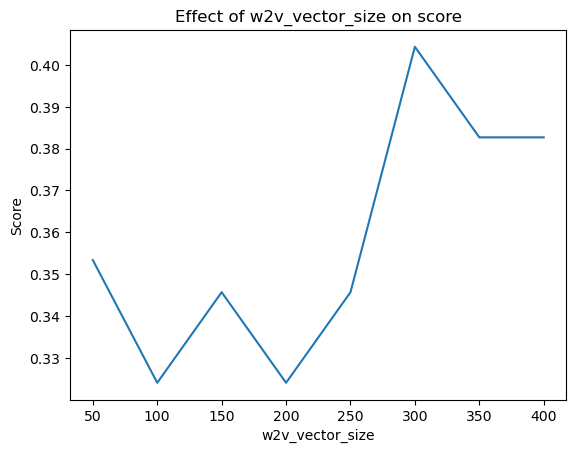

In [42]:
graph_evaluation("w2v_vector_size", range(50,450,50), w2v_window, w2v_vector_size, w2v_min_count, w2v_sg, alpha_value, keep_relevant_documents) 

In [23]:
#graph_evaluation("w2v_window", range(0,110,10), w2v_window, w2v_vector_size, w2v_min_count, w2v_sg, alpha_value, keep_relevant_documents) 

0.5726291241406452
0.5949744028231672
0.47136575642398826


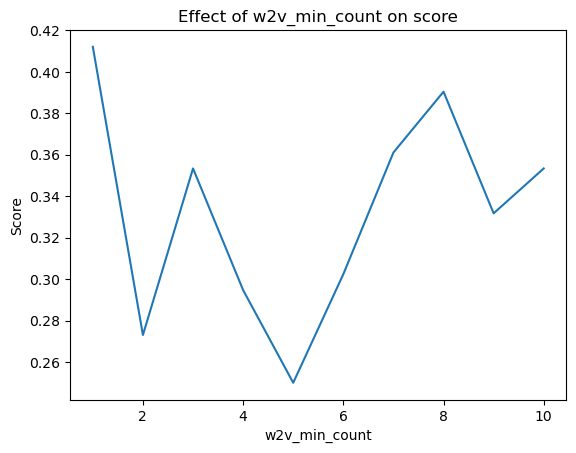

In [47]:
graph_evaluation("w2v_min_count", range(1,11,1), w2v_window, w2v_vector_size, w2v_min_count, w2v_sg, alpha_value, keep_relevant_documents) 

In [21]:
print('CBOW score:', output_score(w2v_window=w2v_window, w2v_vector_size=w2v_vector_size, w2v_min_count=w2v_min_count, w2v_sg=0, alpha_value=alpha_value, keep_relevant_documents=keep_relevant_documents))
print('Skip-gram score:', output_score(w2v_window=w2v_window, w2v_vector_size=w2v_vector_size, w2v_min_count=w2v_min_count, w2v_sg=1, alpha_value=alpha_value, keep_relevant_documents=keep_relevant_documents))

CBOW score: 0.5293299203764223
Skip-gram score: 0.3826803184943109


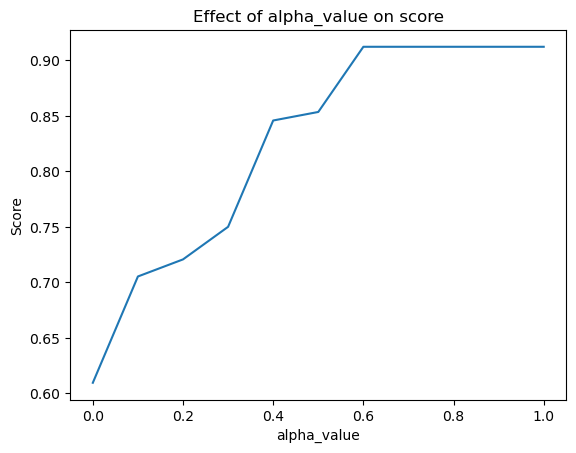

In [26]:
graph_evaluation("alpha_value", np.arange(0,1.1,0.1), w2v_window, w2v_vector_size, w2v_min_count, w2v_sg, alpha_value, keep_relevant_documents) 

In [140]:
# Define the models

corpus = extract_corpus(keep_relevant_documents, start, end)

chosen_model = 4

models = {
    1 : Word2Vec(sentences=corpus[0] + corpus[1], vector_size=w2v_vector_size, window=w2v_window, min_count=w2v_min_count, workers=8, sg=w2v_sg, seed = 42).wv,
    2 : glove_model,
    3 : bio_model,
    4 : pubmed_model
}

model = models[chosen_model]

model.most_similar(positive=['food', 'western', 'risk'], negative=['healthy'], topn=5)

[('seafood', 0.49910032749176025),
 ('Western', 0.4986245334148407),
 ('non-dietary', 0.45837923884391785),
 ('salt-preserved', 0.45231884717941284),
 ('fish-based', 0.4514375329017639)]